# Markov-Chain Monte Carlo in EasyVVUQ

We have a model that returns an array of 50 integers where each is supposed to have come from a Poisson distribution with an unknown mean. The model has four input parameters ```a, b, c, d``` and the values of the means depend on the values of those parameters (albeit indirectly).

In [43]:
def model(a, b, c, d):
    x = np.linspace(0, 1, 50)
    return np.random.poisson(
        a * (0.5 * np.sin(2.0 * np.pi * x) + 1.0) +\
        b * (0.5 * np.sin(4.0 * np.pi * x) + 1.0) +\
        c * (0.5 * np.sin(6.0 * np.pi * x) + 1.0) +\
        d * (0.5 * np.sin(8.0 * np.pi * x) + 1.0))

If we plot the values returned by the model with ```a = b = c = d = 50``` and repeat this 20 times we might get something like the figure below.

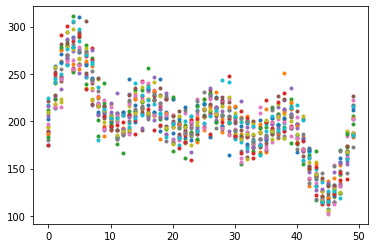

In [50]:
import matplotlib.pyplot as plt
for _ in range(20):
    plt.plot(model(50, 50, 50, 50), '.')

Then we have an array of 50 values that came from the model. With ```a = 50, b = 80, c = 50 and d = 80```. We will treat them as our observed data. We want to know what input parameters of the model are most likely to result in the values in the ```observed``` array. Because suppose we forgot.

In [49]:
observed = np.array([227, 257, 280, 344, 326, 319, 253, 281, 247, 221, 195, 189, 199,
       212, 221, 210, 228, 230, 217, 199, 217, 199, 175, 176, 202, 233,
       246, 284, 292, 260, 264, 220, 204, 227, 220, 232, 228, 253, 244,
       258, 225, 209, 203, 174, 138, 119, 126, 155, 199, 238])

More precisely we are interested in $E(f(a, b, c, d | x))$ with $f$ being the joint probability distribution of the input parameter values given some observed values $x$. We know by Bayes theorem that this is proportional to $E(g(x | a, b, c, d) f(a, b, c, d))$. We will use Markov-Chain Monte Carlo (MCMC) to approximate the probability density $g(x | a, b, c, d)$. Namely the probability density of $x$ taking on given values with respect to the input parameters. We know that $x$ is 50 numbers from 50 Poisson distributions with unknown means. We will estimate those means by running the model multiple times and calculating the sample mean because that is the MLE estimate for a Poisson distributed random variable. Suppose we have $\hat{\lambda}_i$ that is the estimate. Then we have $g(x | a, b, c, d) = \prod_{i = 1}^{50} \frac{\lambda_i^k \exp(-\lambda_i)}{k!}$